In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

## Récupération de certaines données environnementales

In [2]:
# Chemin du fichier Excel
file_path = 'PRODUCTION_SOLAIRE_JANVIER_2024.xlsx'

# Nom de la feuille spécifique
sheet_name = '18-01-24'

try:
    # Charger le fichier Excel pour lister les feuilles disponibles
    xls = pd.ExcelFile(file_path)
    print(f'Feuilles disponibles : {xls.sheet_names}')

    # Lire la feuille spécifique
    if sheet_name in xls.sheet_names:
        df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
        
        # Afficher les dimensions du DataFrame chargé
        print(f'Dimensions du DataFrame de la feuille {sheet_name} : {df.shape}')
        
        # Vérifier si la feuille contient suffisamment de lignes et de colonnes
        if df.shape[0] >= 61 and df.shape[1] >= 14:
            # Extraire les colonnes K à N (indices 10 à 13) et les lignes 42 à 61 (indices 41 à 60)
            extracted_data = df.iloc[41:61, 10:14]
            extracted_data.columns = extracted_data.iloc[0]
            extracted_data = extracted_data.rename(
                                        columns={
                                            'Mois': 'Date',
                                            'PR Totale des Compteurs (%': 'PR_Total_Compteurs',
                                            '%PR de Reference mensuel': 'PR_Reference'
                                        }
                                    )
            extracted_data = extracted_data.iloc[2:]
            extracted_data = extracted_data.reset_index(drop=True)
            extracted_data['Date'] = pd.to_datetime(extracted_data['Date'], errors='coerce').fillna(pd.NaT)
        else:
            print(f'La feuille {sheet_name} ne contient pas suffisamment de lignes ou de colonnes.')
    else:
        print(f'La feuille {sheet_name} n\'existe pas dans le fichier Excel.')

except Exception as e:
    print(f'Une erreur s\'est produite : {e}')

Feuilles disponibles : ['RAPPORT ANNUEL 2023', 'RAPPORT CPV DECEMBRE 2023', '01-01-24', '02-01-24', '03-01-24', '04-01-24', '05-01-24', '06-01-24', '07-01-24', '08-01-24', '09-01-24', '10-01-24', '11-01-24', '12-01-24', '13-01-24', '14-01-24', '15-01-24', '16-01-24', '17-01-24', '18-01-24']
Dimensions du DataFrame de la feuille 18-01-24 : (158, 29)


In [3]:
extracted_data['Nombre_Panneau'] = [85608] * 18
extracted_data['Nombre_Onduleur'] = [32] * 18

In [4]:
extracted_data.head()

41,Date,PR_Total_Compteurs,Ensoleillement,PR_Reference,Nombre_Panneau,Nombre_Onduleur
0,2024-01-01,75.911252,5.68,78.5,85608,32
1,2024-01-02,81.726189,4.18,78.5,85608,32
2,2024-01-03,77.415289,6.26,78.5,85608,32
3,2024-01-04,77.285682,6.19,78.5,85608,32
4,2024-01-05,77.023339,5.67,78.5,85608,32


## Constitution de notre Dataset

In [5]:
dataset_test = pd.read_excel('data.xlsx')

In [6]:
data = dataset_test.iloc[16:]
data = data[data['Energies_Horaires'] > 0]
data = data.reset_index(drop=True)

In [7]:
data = data.drop('Puissances_Horaires', axis=1)

### Ajout des données issues du dataframe extracted_data

In [8]:
dataset = data.merge(extracted_data, how='left', on='Date')

In [9]:
dataset.head()

,Id_ProductionJournaliere,Date,Heures,Meteo_Irradience,Energies_Horaires,PR_Total_Compteurs,Ensoleillement,PR_Reference,Nombre_Panneau,Nombre_Onduleur
0,2,2024-01-01,08:00,29.51,170,75.911252,5.68,78.5,85608,32
1,3,2024-01-01,09:00,176.35,2279,75.911252,5.68,78.5,85608,32
2,4,2024-01-01,10:00,519.68,7850,75.911252,5.68,78.5,85608,32
3,5,2024-01-01,11:00,691.15,10938,75.911252,5.68,78.5,85608,32
4,6,2024-01-01,12:00,821.85,13949,75.911252,5.68,78.5,85608,32


In [10]:
dataset['Heures'] = pd.to_datetime(dataset['Heures'], format='%H:%M').dt.time

## Analyse exploratoire des données (EDA)

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id_ProductionJournaliere  216 non-null    int64         
 1   Date                      216 non-null    datetime64[ns]
 2   Heures                    216 non-null    object        
 3   Meteo_Irradience          216 non-null    float64       
 4   Energies_Horaires         216 non-null    int64         
 5   PR_Total_Compteurs        216 non-null    object        
 6   Ensoleillement            216 non-null    object        
 7   PR_Reference              216 non-null    object        
 8   Nombre_Panneau            216 non-null    int64         
 9   Nombre_Onduleur           216 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 17.0+ KB


In [12]:
dataset.describe()

,Id_ProductionJournaliere,Date,Meteo_Irradience,Energies_Horaires,Nombre_Panneau,Nombre_Onduleur
count,216.000000,216,216.000000,216.000000,216.0,216.0
mean,135.000000,2024-01-09 12:00:00,489.348889,8683.703704,85608.0,32.0
min,2.000000,2024-01-01 00:00:00,9.740000,28.000000,85608.0,32.0
25%,67.750000,2024-01-05 00:00:00,178.472500,3444.250000,85608.0,32.0
50%,135.000000,2024-01-09 12:00:00,524.375000,9244.000000,85608.0,32.0
75%,202.250000,2024-01-14 00:00:00,789.012500,13797.500000,85608.0,32.0
max,268.000000,2024-01-18 00:00:00,1075.730000,17471.000000,85608.0,32.0
std,78.079387,NaN,321.813792,5717.974478,0.0,0.0


In [13]:
dataset.to_csv('dataset.csv')

In [14]:
dataset.columns

Index(['Id_ProductionJournaliere', 'Date', 'Heures', 'Meteo_Irradience',
       'Energies_Horaires', 'PR_Total_Compteurs', 'Ensoleillement',
       'PR_Reference', 'Nombre_Panneau', 'Nombre_Onduleur'],
      dtype='object')


Fréquence des catégories pour 'Heures':
Heures
08:00:00    18
09:00:00    18
10:00:00    18
11:00:00    18
12:00:00    18
13:00:00    18
14:00:00    18
15:00:00    18
16:00:00    18
17:00:00    18
18:00:00    18
19:00:00    18
Name: count, dtype: int64


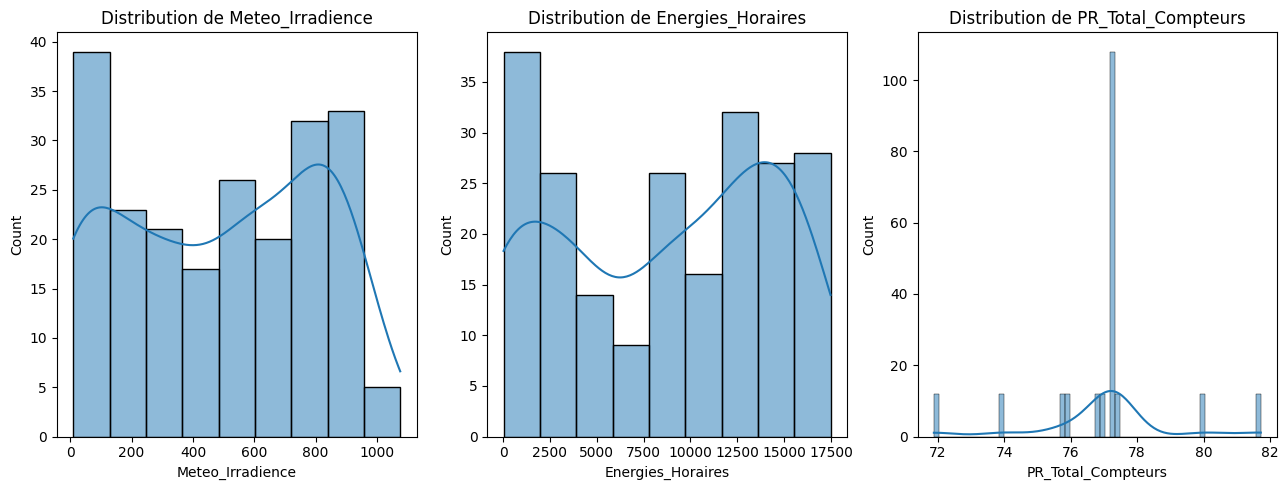

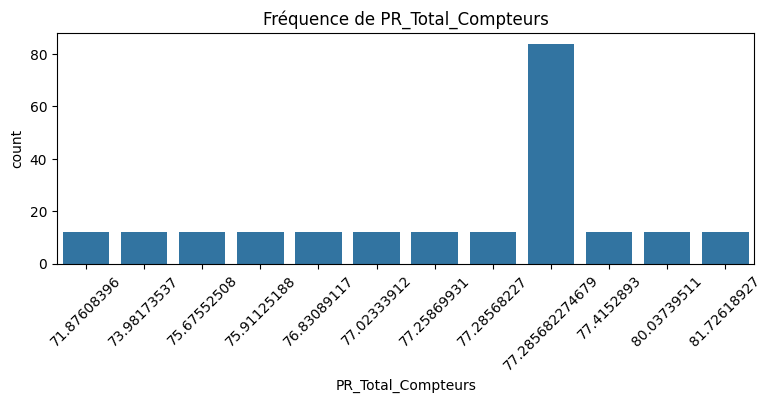

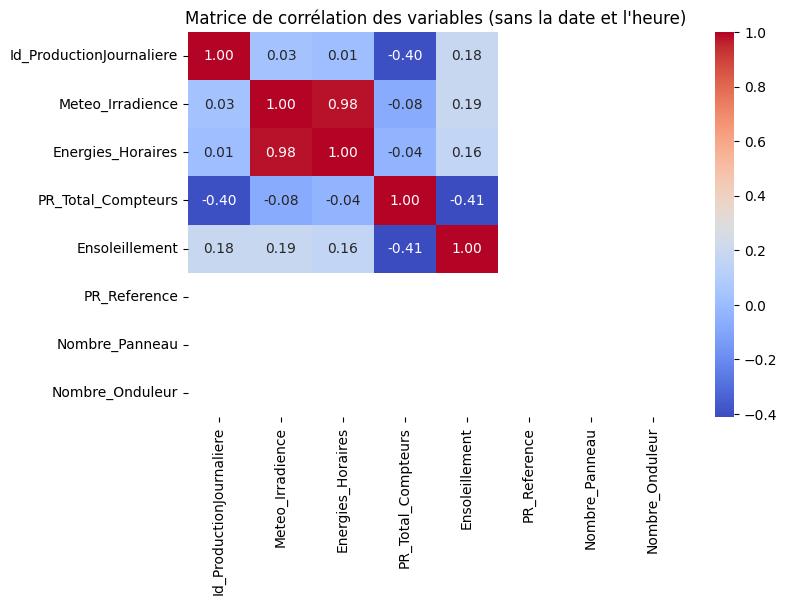

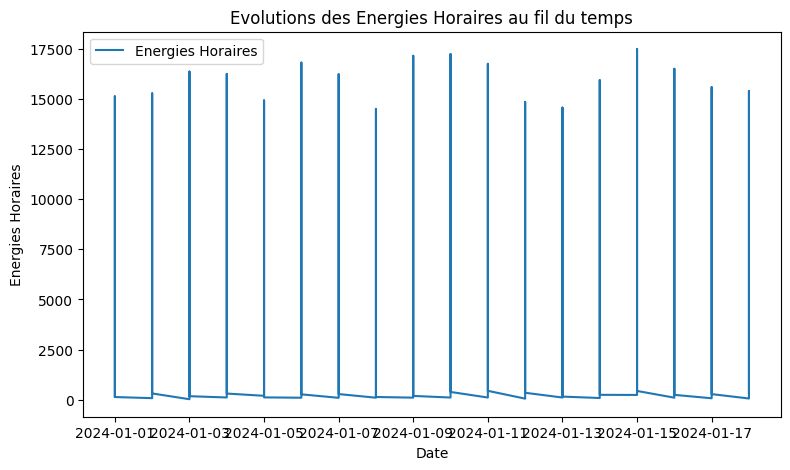


Valeurs manquantes dans le dataset:
Id_ProductionJournaliere    0
Date                        0
Heures                      0
Meteo_Irradience            0
Energies_Horaires           0
PR_Total_Compteurs          0
Ensoleillement              0
PR_Reference                0
Nombre_Panneau              0
Nombre_Onduleur             0
dtype: int64


In [15]:
# Distribution des variables numériques
fig, axs = plt.subplots(1, 3, figsize=(13, 5))
variables_num = ['Meteo_Irradience', 'Energies_Horaires', 'PR_Total_Compteurs']
for var, ax in zip(variables_num, axs.flatten()):
    sns.histplot(dataset[var], kde=True, ax=ax)
    ax.set_title(f'Distribution de {var}')
plt.tight_layout()

# 2. Analyse des variables catégorielles
print("\nFréquence des catégories pour 'Heures':")
print(dataset['Heures'].value_counts())

# Diagrammes à barres pour PR_Total_Compteurs
plt.figure(figsize=(9, 3))
sns.countplot(data=dataset, x='PR_Total_Compteurs')
plt.title("Fréquence de PR_Total_Compteurs")
plt.xticks(rotation=45)
plt.show()

# 3. Analyse de corrélation
corr_columns = dataset.drop(['Date', 'Heures'], axis=1)  # Exclut les colonnes 'Date' et 'Heures' du calcul
plt.figure(figsize=(8, 5))
sns.heatmap(corr_columns.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation des variables (sans la date et l'heure)")
plt.show()

# 4. Analyse temporelle
# Tendances de 'Energies_Horaires' sur le temps
plt.figure(figsize=(9, 5))
plt.plot(dataset['Date'], dataset['Energies_Horaires'], label='Energies Horaires')
plt.title('Evolutions des Energies Horaires au fil du temps')
plt.xlabel('Date')
plt.ylabel('Energies Horaires')
plt.legend()
plt.show()

# 5. Analyse des valeurs manquantes
print("\nValeurs manquantes dans le dataset:")
print(dataset.isnull().sum())

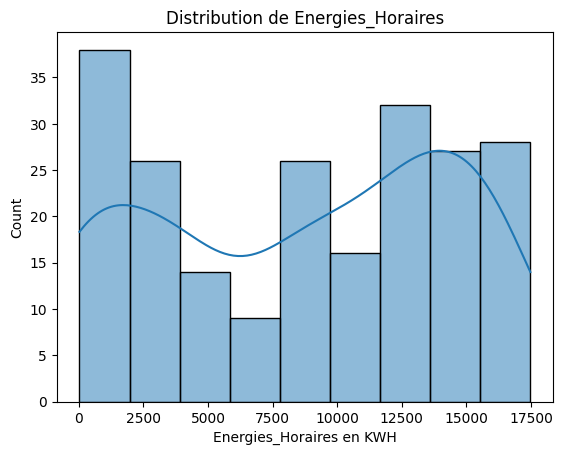

In [16]:
# Distribution de la variable cible
sns.histplot(dataset['Energies_Horaires'], kde=True)
plt.title('Distribution de Energies_Horaires')
plt.xlabel('Energies_Horaires en KWH')
plt.show()

1. Distribution Asymétrique :

    * La distribution est fortement asymétrique à droite. Une grande partie des observations se trouve dans les premières classes d'énergie horaire, proches de zéro.
    * Cela peut indiquer que la centrale solaire produit souvent peu d'énergie par heure, avec des pics occasionnels de production plus élevée.
2. Présence de Zéros ou de Valeurs Très Basses :

    * Le pic élevé à zéro ou proche de zéro peut suggérer des périodes fréquentes où la production est nulle ou très faible.
    * Il pourrait être utile de comprendre pourquoi ces valeurs sont si fréquentes. Cela pourrait être dû à des périodes de maintenance, des conditions météorologiques défavorables, ou d'autres facteurs opérationnels.
3. Distribution Multimodale :

    * En dehors du pic initial, la distribution semble avoir plusieurs pics (multimodale). Cela peut suggérer qu'il existe plusieurs régimes de production dans la centrale solaire, peut-être en fonction de différentes conditions météorologiques ou d'autres variables contextuelles.

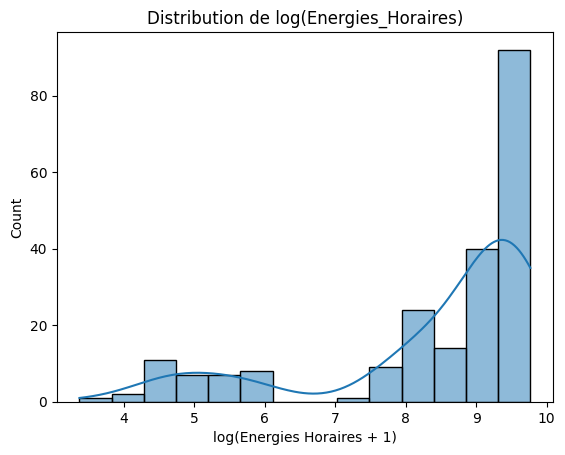

In [17]:
# Transformer la variable cible
dataset['log_Energies_Horaires'] = np.log1p(dataset['Energies_Horaires'])

# Visualiser la distribution transformée
sns.histplot(dataset['log_Energies_Horaires'], kde=True)
plt.title('Distribution de log(Energies_Horaires)')
plt.xlabel('log(Energies Horaires + 1)')
plt.ylabel('Count')
plt.show()

In [18]:
# Pré-traitement des données
# Supprimer les colonnes inutiles ou ayant trop de valeurs manquantes
dataset = dataset.drop(columns=['Id_ProductionJournaliere'])  # Supprimer l'ID qui n'est pas utile pour la prédiction


In [19]:
# Séparer les caractéristiques et la variable cible transformée
X = dataset.drop(columns=['Energies_Horaires', 'log_Energies_Horaires'])

y = dataset['log_Energies_Horaires']
# y = dataset['Energies_Horaires']

# Encodage des variables catégorielles et normalisation des données
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Entraînement de plusieurs modèles de machine learning
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Support Vector Regressor': SVR(),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

In [20]:
results = {}

for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    
    # Entraînement du modèle
    pipeline.fit(X_train, y_train)
    
    # Prédiction sur les données de test
    y_pred = pipeline.predict(X_test)
    
    # Évaluation du modèle
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[model_name] = {'MSE': mse, 'R^2': r2}

In [21]:
# Afficher les résultats
results_df = pd.DataFrame(results).T
print(results_df)

                               MSE       R^2
Linear Regression         0.022979  0.985896
Random Forest             0.010535  0.993534
Support Vector Regressor  0.047783  0.970672
Decision Tree             0.014293  0.991227


In [22]:
# Sélection du meilleur modèle et prédiction
best_model_name = results_df['R^2'].idxmax()
best_model = models[best_model_name]

# Entraînement du meilleur modèle sur l'ensemble des données
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', best_model)])

final_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Meteo_Irradience', 'Nombre_Panneau', 'Nombre_Onduleur'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Heures', 'PR_Total_Compteurs', 'Ensoleillement', 'PR_Reference'], dtype='object'))])),
                ('model', RandomForestRegressor(random_state=42))])

## Optimisation de notre meilleur modèle

In [ ]:
from sklearn.model_selection import GridSearchCV

# Configuration des hyperparamètres à tester
param_grid = {
    'model__n_estimators': [100, 200, 300],  # Plusieurs valeurs pour le nombre d'arbres
    'model__max_depth': [None, 10, 20, 30],  # Profondeurs différentes, None signifie pas de limite
    'model__min_samples_split': [2, 5, 10],  # Le nombre minimum de données requises pour scinder un nœud
    'model__min_samples_leaf': [1, 2, 4]  # Le nombre minimum de données requises dans un nœud terminal
}

# Création du pipeline avec prétraitement et le modèle
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', RandomForestRegressor(random_state=42))])

# Configuration de GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Exécution du GridSearchCV
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres et du meilleur score
print("Meilleurs paramètres trouvés: ", grid_search.best_params_)
print("Meilleur MSE obtenu: ", -grid_search.best_score_)

# Évaluation avec les meilleurs paramètres sur l'ensemble de test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE sur les données de test: ", mse)
print("R² sur les données de test: ", r2)

In [85]:
sample_data = X_test.iloc[0]
sample_data

Date                  2024-01-17 00:00:00
Heures                           17:00:00
Meteo_Irradience                   311.38
PR_Total_Compteurs              71.876084
Ensoleillement                       5.73
PR_Reference                         78.5
Nombre_Panneau                      85608
Nombre_Onduleur                        32
Name: 201, dtype: object

In [ ]:
{
  "Date": "2024-01-17",
  "Heure": "17:00:00",
  "Meteo_Irradience": 311.38,
  "PR_Total_Compteurs": 71.876084,
  "Ensoleillement": 5.73,
  "PR_Reference": 78.5,
  "Nombre_Panneau": 85608,
  "Nombre_Onduleur": 32
}

In [86]:
# Sauvegarder le modèle
import numpy as np
import joblib
joblib.dump(final_pipeline, './models/best_model.pkl')

['./models/best_model.pkl']

In [87]:
# Charger le modèle et faire des prédictions
loaded_model = joblib.load('./models/best_model.pkl')
sample_data = X_test.iloc[[0]]
sample_predictions = loaded_model.predict(sample_data)

print("Predictions for sample data:")
print(sample_predictions)
print("Predictions for sample data (original scale):")
print(np.expm1(sample_predictions))

Predictions for sample data:
[8.75526301]
Predictions for sample data (original scale):
[6342.98885432]


In [77]:
sample_data

,Date,Heures,Meteo_Irradience,PR Totale des Compteurs (%),Ensoleillement,%PR de Reference mensuel,Nombre de Panneau solaire,Nombre Onduleurs
201,2024-01-17,17:00:00,311.38,71.876084,5.73,78.5,85608,32


In [42]:
from sklearn.metrics import mean_squared_error, r2_score

# Prédictions sur l'ensemble d'entraînement
y_train_pred = pipeline.predict(X_train)

# Prédictions sur l'ensemble de test
y_test_pred = pipeline.predict(X_test)

# Calcul de l'erreur quadratique moyenne (RMSE) pour l'ensemble d'entraînement
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Calcul de l'erreur quadratique moyenne (RMSE) pour l'ensemble de test
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

# Calcul du R^2 pour l'ensemble d'entraînement
r2_train = r2_score(y_train, y_train_pred)

# Calcul du R^2 pour l'ensemble de test
r2_test = r2_score(y_test, y_test_pred)

print(f"RMSE Entraînement: {rmse_train}")
print(f"R^2 Entraînement: {r2_train}")
print(f"RMSE Test: {rmse_test}")
print(f"R^2 Test: {r2_test}")

RMSE Entraînement: 0.3014446731863921
R^2 Entraînement: 0.9680203450258517
RMSE Test: 0.2958578246483231
R^2 Test: 0.9462747421126975


c:\Users\ACER\OneDrive - ESMT\Bureau\Central Solaire\Application\env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ACER\OneDrive - ESMT\Bureau\Central Solaire\Application\env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [32]:
X_test.head()

,Date,Heures,Meteo_Irradience,PR Totale des Compteurs (%),Ensoleillement,%PR de Reference mensuel,Nombre de Panneau solaire,Nombre Onduleurs
250,2024-01-17,17:00:00,311.38,71.876084,5.73,78.5,85608,32
265,2024-01-18,17:00:00,369.88,77.285682,5.77,78.5,85608,32
172,2024-01-12,14:00:00,787.72,77.285682,4.71,78.5,85608,32
220,2024-01-15,17:00:00,430.59,73.981735,7.23,78.5,85608,32
19,2024-01-02,11:00:00,268.91,81.726189,4.18,78.5,85608,32


In [44]:
from sklearn.model_selection import KFold, cross_val_score


# K-Fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_test, y_test, cv=cv, scoring='neg_root_mean_squared_error')

cv_mean = -cv_scores.mean()  # Prendre la moyenne des scores négatifs
cv_std = cv_scores.std()

print(f"RMSE Cross-Validation: {cv_mean}")
print(f"Écart-Type Cross-Validation: {cv_std}")

RMSE Cross-Validation: 0.22363226550709697
Écart-Type Cross-Validation: 0.08352615705956506


In [43]:
from sklearn.model_selection import cross_val_score

# Calcul des scores de validation croisée
cv_scores = cross_val_score(pipeline, X_test, y_test, cv=5, scoring='neg_root_mean_squared_error')

# Calcul de la moyenne et de l'écart type des scores
cv_mean = -cv_scores.mean()  # Prendre la moyenne des scores négatifs
cv_std = cv_scores.std()

print(f"RMSE Cross-Validation: {cv_mean}")
print(f"Écart-Type Cross-Validation: {cv_std}")

RMSE Cross-Validation: 0.2296527716934841
Écart-Type Cross-Validation: 0.09406595391879972


In [29]:
sample_data

,Date,Heures,Meteo_Irradience,PR Totale des Compteurs (%),Ensoleillement,%PR de Reference mensuel,Nombre de Panneau solaire,Nombre Onduleurs
250,2024-01-17,17:00:00,311.38,71.876084,5.73,78.5,85608,32
265,2024-01-18,17:00:00,369.88,77.285682,5.77,78.5,85608,32
172,2024-01-12,14:00:00,787.72,77.285682,4.71,78.5,85608,32
220,2024-01-15,17:00:00,430.59,73.981735,7.23,78.5,85608,32
19,2024-01-02,11:00:00,268.91,81.726189,4.18,78.5,85608,32


In [100]:
import os
from dotenv import load_dotenv
import requests
import pandas as pd

load_dotenv()
key = os.getenv('SOLCAST_API_KEY')

In [119]:
headers = {
    "Authorization": f"Bearer {key}"
  }

lat = -33.856784
lon = 151.215297
start = "2021-10-25T14:45:00.000Z"
duration = "PT30M" # maximum duration is 30 days
format_ = "json"
hours = 1
time_zone = "utc"
output_parameters = "air_temp,dni,ghi"

# url = f"https://api.solcast.com.au/data/forecast/radiation_and_weather?latitude={lat}&longitude={lon}&hours={hours}&period={duration}&output_parameters={output_parameters}&format={format_}"
url = f"https://api.solcast.com.au/data/forecast/radiation_and_weather?latitude=-33.865143&longitude=151.209900&hours=24&period=PT30M&output_parameters=air_temp%2Cdni%2Cghi&format=json"

response = requests.get(url, headers=headers)

In [120]:
response

<Response [403]>

In [94]:
def get_solar_data(lat, lon, start_date, duration, hours, output_parameters, api_key, time_zone='utc', format_='json'):
  """
  Cette fonction récupère les données solaires à partir de l'API SolCast.

  Args:
    lat (float): Latitude du lieu.
    lon (float): Longitude du lieu.
    start_date (str): Date au format AAAA-MM-JJ.
    duration (str): Longueur d'intervalle de temps au format ISO 8601.
    hours (int) : Fenêtre temporelle de la réponse en heures de 1 à 336
    output_parameters (str): Defini les types de données solaires à récupérer.
    api_key (str): Clé API.
    time_zone (str): Time zone (utc).
    format_ (str): Format de récupération des données de l'API. Par defaut en JSON.

  Returns:
    dict: Un dictionnaire contenant les données solaires ou None en cas d'erreur.
  """

  headers = {
    "Authorization": f"Bearer {api_key}"
  }

  url = f"https://api.solcast.com.au/data/forecast/radiation_and_weather?latitude={lat}&longitude={lon}&hours={hours}&period={duration}&output_parameters={output_parameters}&format={format_}"
  url = f"https://api.solcast.com.au/data/historic/radiation_and_weather?latitude={lat}&longitude={lon}&start={start_date}&duration={duration}&format={format_}&time_zone={time_zone}&output_parameters={output_parameters}"

  try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Raise an exception for error HTTP status codes
    data = response.json()
    return data
  except requests.exceptions.RequestException as e:
    print(f"Une erreur s'est produite lors de la requête : {e}")
    return None

In [96]:
# Exemple d'utilisation :
api_key =  'f43e1Qte1ZtYHj_h9J0wnpxE32w2BBVJ'  # Remplacez par votre clé API réelle
lat = 48.8566  # Paris
lon = 2.3522  # Paris
date = "2024-04-20"

solar_data = get_solar_data(lat, lon, date, api_key)

if solar_data:
  print(solar_data)
else:
  print("Impossible de récupérer les données solaires.")

{'cod': '200', 'message': 0, 'cnt': 40, 'list': [{'dt': 1726023600, 'main': {'temp': 288.32, 'feels_like': 288.24, 'temp_min': 288.32, 'temp_max': 288.48, 'pressure': 1010, 'sea_level': 1010, 'grnd_level': 999, 'humidity': 90, 'temp_kf': -0.16}, 'weather': [{'id': 500, 'main': 'Rain', 'description': 'light rain', 'icon': '10n'}], 'clouds': {'all': 100}, 'wind': {'speed': 4.96, 'deg': 282, 'gust': 11.22}, 'visibility': 10000, 'pop': 1, 'rain': {'3h': 0.81}, 'sys': {'pod': 'n'}, 'dt_txt': '2024-09-11 03:00:00'}, {'dt': 1726034400, 'main': {'temp': 287.2, 'feels_like': 286.8, 'temp_min': 286.68, 'temp_max': 287.2, 'pressure': 1011, 'sea_level': 1011, 'grnd_level': 1001, 'humidity': 82, 'temp_kf': 0.52}, 'weather': [{'id': 500, 'main': 'Rain', 'description': 'light rain', 'icon': '10d'}], 'clouds': {'all': 100}, 'wind': {'speed': 3.73, 'deg': 306, 'gust': 8.86}, 'visibility': 10000, 'pop': 1, 'rain': {'3h': 1.26}, 'sys': {'pod': 'd'}, 'dt_txt': '2024-09-11 06:00:00'}, {'dt': 1726045200, 'm

In [2]:
# from database import create_engine_mysql
from sqlalchemy import create_engine
import pandas as pd

def create_engine_mysql():
    user = 'root'
    password = ''
    host = '127.0.0.1'
    database = 'solaire_db'
    engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{database}', echo=False)
    return engine

conn = create_engine_mysql()

df = pd.read_csv('dataset.csv')

df.to_sql('Table_test', con=conn, if_exists='replace', index=False)

print("Success")

Success


C:\Users\ACER\AppData\Local\Temp\ipykernel_22048\3809117531.py:17: UserWarning: The provided table name 'Table_test' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  df.to_sql('Table_test', con=conn, if_exists='replace', index=False)
